In [99]:
!pip install --upgrade category_encoders

!pip install eli5
!pip install xgboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [120]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files

In [121]:
from sklearn.metrics import accuracy_score
from category_encoders import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from xgboost import XGBClassifier
import xgboost

In [122]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# DAICON 쇼핑몰 지점별 매출액 예측 경진대회

발표자 강인구 

#1. EDA

In [141]:
sample_submission = pd.read_csv('/content/drive/MyDrive/Dataset/sample_submission.csv')
train = pd.read_csv('/content/drive/MyDrive/Dataset/train.csv')
test = pd.read_csv('/content/drive/MyDrive/Dataset/test.csv')

In [142]:
train.head()

,id,Store,Date,Temperature,Fuel_Price,Promotion1,Promotion2,Promotion3,Promotion4,Promotion5,Unemployment,IsHoliday,Weekly_Sales
0,1,1,05/02/2010,42.31,2.572,NaN,NaN,NaN,NaN,NaN,8.106,False,1643690.90
1,2,1,12/02/2010,38.51,2.548,NaN,NaN,NaN,NaN,NaN,8.106,True,1641957.44
2,3,1,19/02/2010,39.93,2.514,NaN,NaN,NaN,NaN,NaN,8.106,False,1611968.17
3,4,1,26/02/2010,46.63,2.561,NaN,NaN,NaN,NaN,NaN,8.106,False,1409727.59
4,5,1,05/03/2010,46.50,2.625,NaN,NaN,NaN,NaN,NaN,8.106,False,1554806.68


In [43]:
train.isnull().sum()

id                 0
Store              0
Date               0
Temperature        0
Fuel_Price         0
Promotion1      4153
Promotion2      4663
Promotion3      4370
Promotion4      4436
Promotion5      4140
Unemployment       0
IsHoliday          0
Weekly_Sales       0
dtype: int64

In [44]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6255 entries, 0 to 6254
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            6255 non-null   int64  
 1   Store         6255 non-null   int64  
 2   Date          6255 non-null   object 
 3   Temperature   6255 non-null   float64
 4   Fuel_Price    6255 non-null   float64
 5   Promotion1    2102 non-null   float64
 6   Promotion2    1592 non-null   float64
 7   Promotion3    1885 non-null   float64
 8   Promotion4    1819 non-null   float64
 9   Promotion5    2115 non-null   float64
 10  Unemployment  6255 non-null   float64
 11  IsHoliday     6255 non-null   bool   
 12  Weekly_Sales  6255 non-null   float64
dtypes: bool(1), float64(9), int64(2), object(1)
memory usage: 592.6+ KB


Promotion 같은 경우 행사에 따른 정보로 float 형태인 것을 보아 데이터 값이 행사로 인한 판매량이나 판매금액 또는 퍼센트를 알려주는 것인 것을 알 수 있다.

In [143]:
train=train.fillna(0)
test=test.fillna(0)
sample_submission=sample_submission.fillna(0)

In [46]:
train.head()

,id,Store,Date,Temperature,Fuel_Price,Promotion1,Promotion2,Promotion3,Promotion4,Promotion5,Unemployment,IsHoliday,Weekly_Sales
0,1,1,05/02/2010,42.31,2.572,0.0,0.0,0.0,0.0,0.0,8.106,False,1643690.90
1,2,1,12/02/2010,38.51,2.548,0.0,0.0,0.0,0.0,0.0,8.106,True,1641957.44
2,3,1,19/02/2010,39.93,2.514,0.0,0.0,0.0,0.0,0.0,8.106,False,1611968.17
3,4,1,26/02/2010,46.63,2.561,0.0,0.0,0.0,0.0,0.0,8.106,False,1409727.59
4,5,1,05/03/2010,46.50,2.625,0.0,0.0,0.0,0.0,0.0,8.106,False,1554806.68


In [144]:
def toDateTime(df):
  df['Date']= pd.to_datetime(df['Date'], format='%d/%m/%Y')
  return df

In [145]:
train= toDateTime(train)
test = toDateTime(test)

In [49]:
train.sort_values(by =['Date'], inplace= True, ascending= False)
train[train['Store']==1].head(28)

,id,Store,Date,Temperature,Fuel_Price,Promotion1,Promotion2,Promotion3,Promotion4,Promotion5,Unemployment,IsHoliday,Weekly_Sales
138,139,1,2012-09-28,76.08,3.666,3666.27,7.64,1.65,1417.96,4744.28,6.908,False,1437059.26
137,138,1,2012-09-21,69.87,3.721,6352.30,7.64,4.69,1010.06,6456.71,6.908,False,1506126.06
136,137,1,2012-09-14,74.97,3.717,17212.52,7.00,18.79,1523.11,7992.72,6.908,False,1517428.87
135,136,1,2012-09-07,83.96,3.730,5204.68,35.74,50.94,4120.32,2737.17,6.908,True,1661767.33
134,135,1,2012-08-31,80.49,3.638,21442.73,102.32,21.70,13209.64,3032.96,6.908,False,1582083.40
133,134,1,2012-08-24,77.66,3.620,6237.83,260.06,2.97,3463.03,7988.25,6.908,False,1494122.38
132,133,1,2012-08-17,84.85,3.571,3662.06,137.86,4.84,2752.20,3446.15,6.908,False,1597868.05
131,132,1,2012-08-10,85.05,3.494,11436.22,245.00,6.85,6964.26,4836.22,6.908,False,1592409.97
130,131,1,2012-08-03,86.11,3.417,27584.78,119.98,30.23,12007.04,4661.71,6.908,False,1631135.79
129,130,1,2012-07-27,82.66,3.407,7146.90,389.02,1.59,10267.54,4325.19,6.908,False,1439123.71


In [13]:
train.sort_values(by =['Date'], inplace= True, ascending= True)
train[train['Store']==1].head(30)

,id,Store,Date,Temperature,Fuel_Price,Promotion1,Promotion2,Promotion3,Promotion4,Promotion5,Unemployment,IsHoliday,Weekly_Sales
0,1,1,2010-02-05,42.31,2.572,0.0,0.0,0.0,0.0,0.0,8.106,False,1643690.90
1,2,1,2010-02-12,38.51,2.548,0.0,0.0,0.0,0.0,0.0,8.106,True,1641957.44
2,3,1,2010-02-19,39.93,2.514,0.0,0.0,0.0,0.0,0.0,8.106,False,1611968.17
3,4,1,2010-02-26,46.63,2.561,0.0,0.0,0.0,0.0,0.0,8.106,False,1409727.59
4,5,1,2010-03-05,46.50,2.625,0.0,0.0,0.0,0.0,0.0,8.106,False,1554806.68
5,6,1,2010-03-12,57.79,2.667,0.0,0.0,0.0,0.0,0.0,8.106,False,1439541.59
6,7,1,2010-03-19,54.58,2.720,0.0,0.0,0.0,0.0,0.0,8.106,False,1472515.79
7,8,1,2010-03-26,51.45,2.732,0.0,0.0,0.0,0.0,0.0,8.106,False,1404429.92
8,9,1,2010-04-02,62.27,2.719,0.0,0.0,0.0,0.0,0.0,7.808,False,1594968.28
9,10,1,2010-04-09,65.86,2.770,0.0,0.0,0.0,0.0,0.0,7.808,False,1545418.53


여기서 데이터는 2010-02-05부터 2012-09-28까지의 조사한 것을 알 수 있다 즉 해당 숫자에서 한 20퍼센트만 validation 값으로 넣는다

In [50]:
train['Date'].value_counts()

2012-09-28    45
2010-12-03    45
2011-01-14    45
2011-01-07    45
2010-12-31    45
              ..
2011-12-23    45
2011-12-30    45
2012-01-06    45
2012-01-13    45
2010-02-05    45
Name: Date, Length: 139, dtype: int64

In [51]:
train['Date'].sort_values()

0      2010-02-05
5977   2010-02-05
278    2010-02-05
2085   2010-02-05
4170   2010-02-05
          ...    
138    2012-09-28
6115   2012-09-28
1667   2012-09-28
2501   2012-09-28
6254   2012-09-28
Name: Date, Length: 6255, dtype: datetime64[ns]

해당 지점수 만큼 공통된 날짜를 가지고 있고 데이트는 139의 데이터가 있으니 



In [146]:
cutOff = pd.to_datetime('2012-03-23')
trains = train[train['Date'] < cutOff]
vals = train[(train['Date'] >= cutOff)]


In [53]:
trains.shape, vals.shape

((4995, 13), (1260, 13))

#기준 모델 제작(Linear Regression)

In [147]:
def Date_to_int(train):
  train['Date'] = train['Date'].apply(lambda x: x.strftime('%Y%m%d'))
  train['Date'] = train['Date'].astype(int)
  return train

In [148]:
trains = Date_to_int(trains)
vals = Date_to_int(vals)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


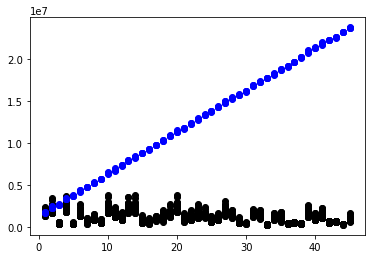

In [151]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
target = 'Weekly_Sales'

## X_train, y_train, X_test, y_test 데이터로 분리
X_train = trains.drop(columns=target)
y_train = trains[target]
X_val = vals.drop(columns=target)
y_val = vals[target]
test_notime = test.drop(['Date'],axis=1)
X_train_notime = X_train.drop(['Date'],axis=1)
X_val_notime = X_val.drop(['Date'],axis=1)

model.fit(X_train_notime, y_train)
y_pred = model.predict(test_notime)
plt.scatter(X_train_notime['Store'], y_train, color='black', linewidth=1)
plt.scatter(test_notime['Store'], y_pred, color='blue', linewidth=1);


In [152]:
print('검증 정확도', model.score(X_val_notime, y_val))


검증 정확도 0.24112176922167228


In [57]:
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score

def RMSE(y, y_pred):
    return mean_squared_error(y, y_pred)**0.5

In [58]:
y_pred = model.predict(X_train_notime)
rmse = RMSE(y_train, y_pred)
print(f"RMSE : {rmse:.2f}")

RMSE : 524206.26


#**해당 dataset분석**

##1. train.csv : 학습 데이터

*  id : 샘플 아이디

*  Store : 쇼핑몰 지점

*  Date : 주 단위(Weekly) 날짜

*  Temperature : 해당 쇼핑몰 주변 기온(F)

*  Fuel_Price : 해당 쇼핑몰 주변 연료 가격

*  Promotion 1~5 : 해당 쇼핑몰의 비식별화된 프로모션 정보

*  Unemployment : 해당 쇼핑몰 지역의 실업률

*  IsHoliday : 해당 기간의 공휴일 포함 여부

*  Weekly_Sales : 주간 매출액 (목표 예측값)


##2. test.csv : 테스트 데이터

*  id : 샘플 아이디

*  Store : 쇼핑몰 지점

*  Date : 주 단위(Weekly) 날짜

*  Temperature : 해당 쇼핑몰 주변 기온(F)

*  Fuel_Price : 해당 쇼핑몰 주변 연료 가격

*  Promotion 1~5 : 해당 쇼핑몰의 비식별화된 프로모션 정보

*  Unemployment : 해당 쇼핑몰 지역의 실업률

*  IsHoliday : 해당 기간의 공휴일 포함 여부

##3. Target : Weekly_Sales 


In [59]:
target = 'Weekly_Sales'

## X_train, y_train, X_test, y_test 데이터로 분리
X_train = trains.drop(columns=target)
y_train = trains[target]
X_val = vals.drop(columns=target)
y_val = vals[target]

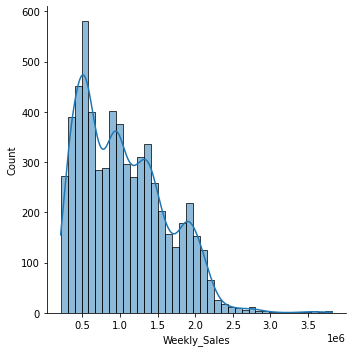

In [60]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.displot(train['Weekly_Sales'],kde=True);

In [61]:
from sklearn.feature_selection import f_regression, SelectKBest
## selctor 정의합니다.
selector = SelectKBest(score_func=f_regression, k=7)

## 학습데이터에 fit_transform 
X_train_selected = selector.fit_transform(X_train, y_train)

## 테스트 데이터는 transform
X_val_selected = selector.transform(X_val)


X_train_selected.shape, X_val_selected.shape

((4995, 7), (1260, 7))

In [62]:
all_names = X_train.columns

## selector.get_support()
selected_mask = selector.get_support()

## 선택된 특성들
selected_names = all_names[selected_mask]

## 선택되지 않은 특성들
unselected_names = all_names[~selected_mask] 

print('Selected names: ', selected_names)
print('Unselected names: ', unselected_names)

Selected names:  Index(['id', 'Store', 'Promotion1', 'Promotion3', 'Promotion4', 'Promotion5',
       'Unemployment'],
      dtype='object')
Unselected names:  Index(['Date', 'Temperature', 'Fuel_Price', 'Promotion2', 'IsHoliday'], dtype='object')


In [63]:
model = LinearRegression()
model.fit(X_train_selected, y_train)
y_pred = model.predict(X_train_selected)
rmse = RMSE(y_train, y_pred)
y_pred = model.predict(X_val_selected)
rmse = RMSE(y_pred, y_val)


In [64]:
print("RMSE : ",rmse)

RMSE :  468796.1597785116


선형 회귀 기존으로는 문제가 많다 한번 더 다른 실험을 해보자. 


문제가 많은 이유 : 선택된 특성이 모델의 결과에 제대로 반영되지 못했다

In [65]:
train.Store.value_counts(sort=True)

45    139
33    139
44    139
1     139
10    139
34    139
35    139
39    139
16    139
26    139
27    139
18    139
41    139
4     139
17    139
29    139
28    139
6     139
30    139
19    139
5     139
12    139
24    139
2     139
21    139
7     139
15    139
38    139
42    139
3     139
31    139
14    139
8     139
37    139
20    139
25    139
43    139
32    139
11    139
13    139
9     139
36    139
23    139
22    139
40    139
Name: Store, dtype: int64

즉 모든 지점의 고유한 데이터 값은 139개이다. 

추가적으로 

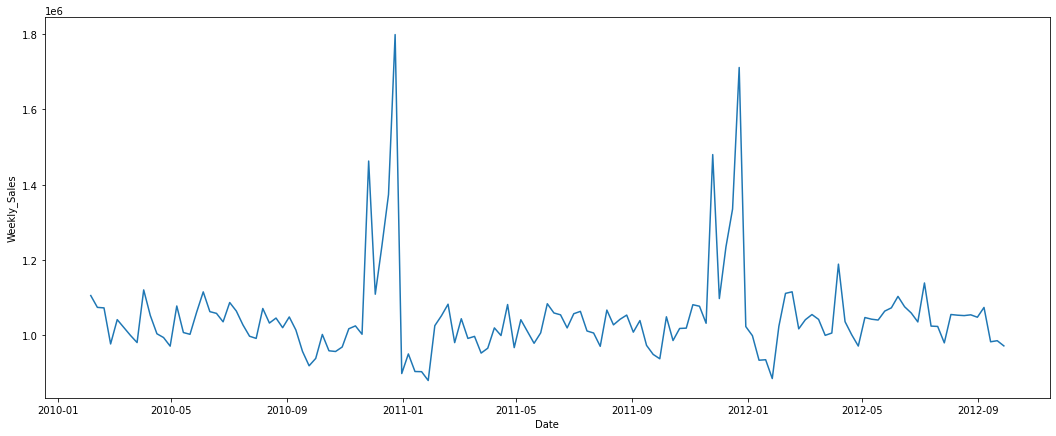

In [66]:
plt.figure(figsize=(18, 7))
sns.lineplot(data=train, x="Date", y="Weekly_Sales", ci=None)
plt.show()

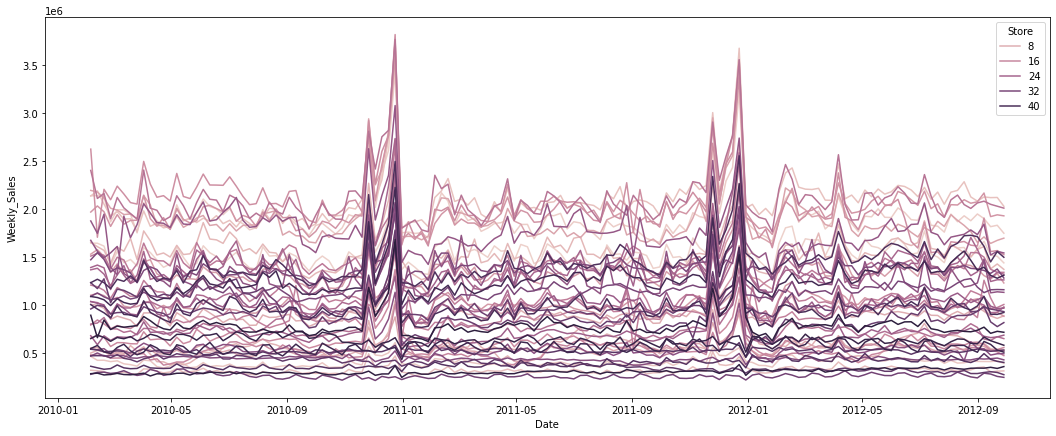

In [67]:
plt.figure(figsize=(18, 7))
sns.lineplot(data=train, x="Date", y="Weekly_Sales", ci=None, hue="Store")
plt.show()

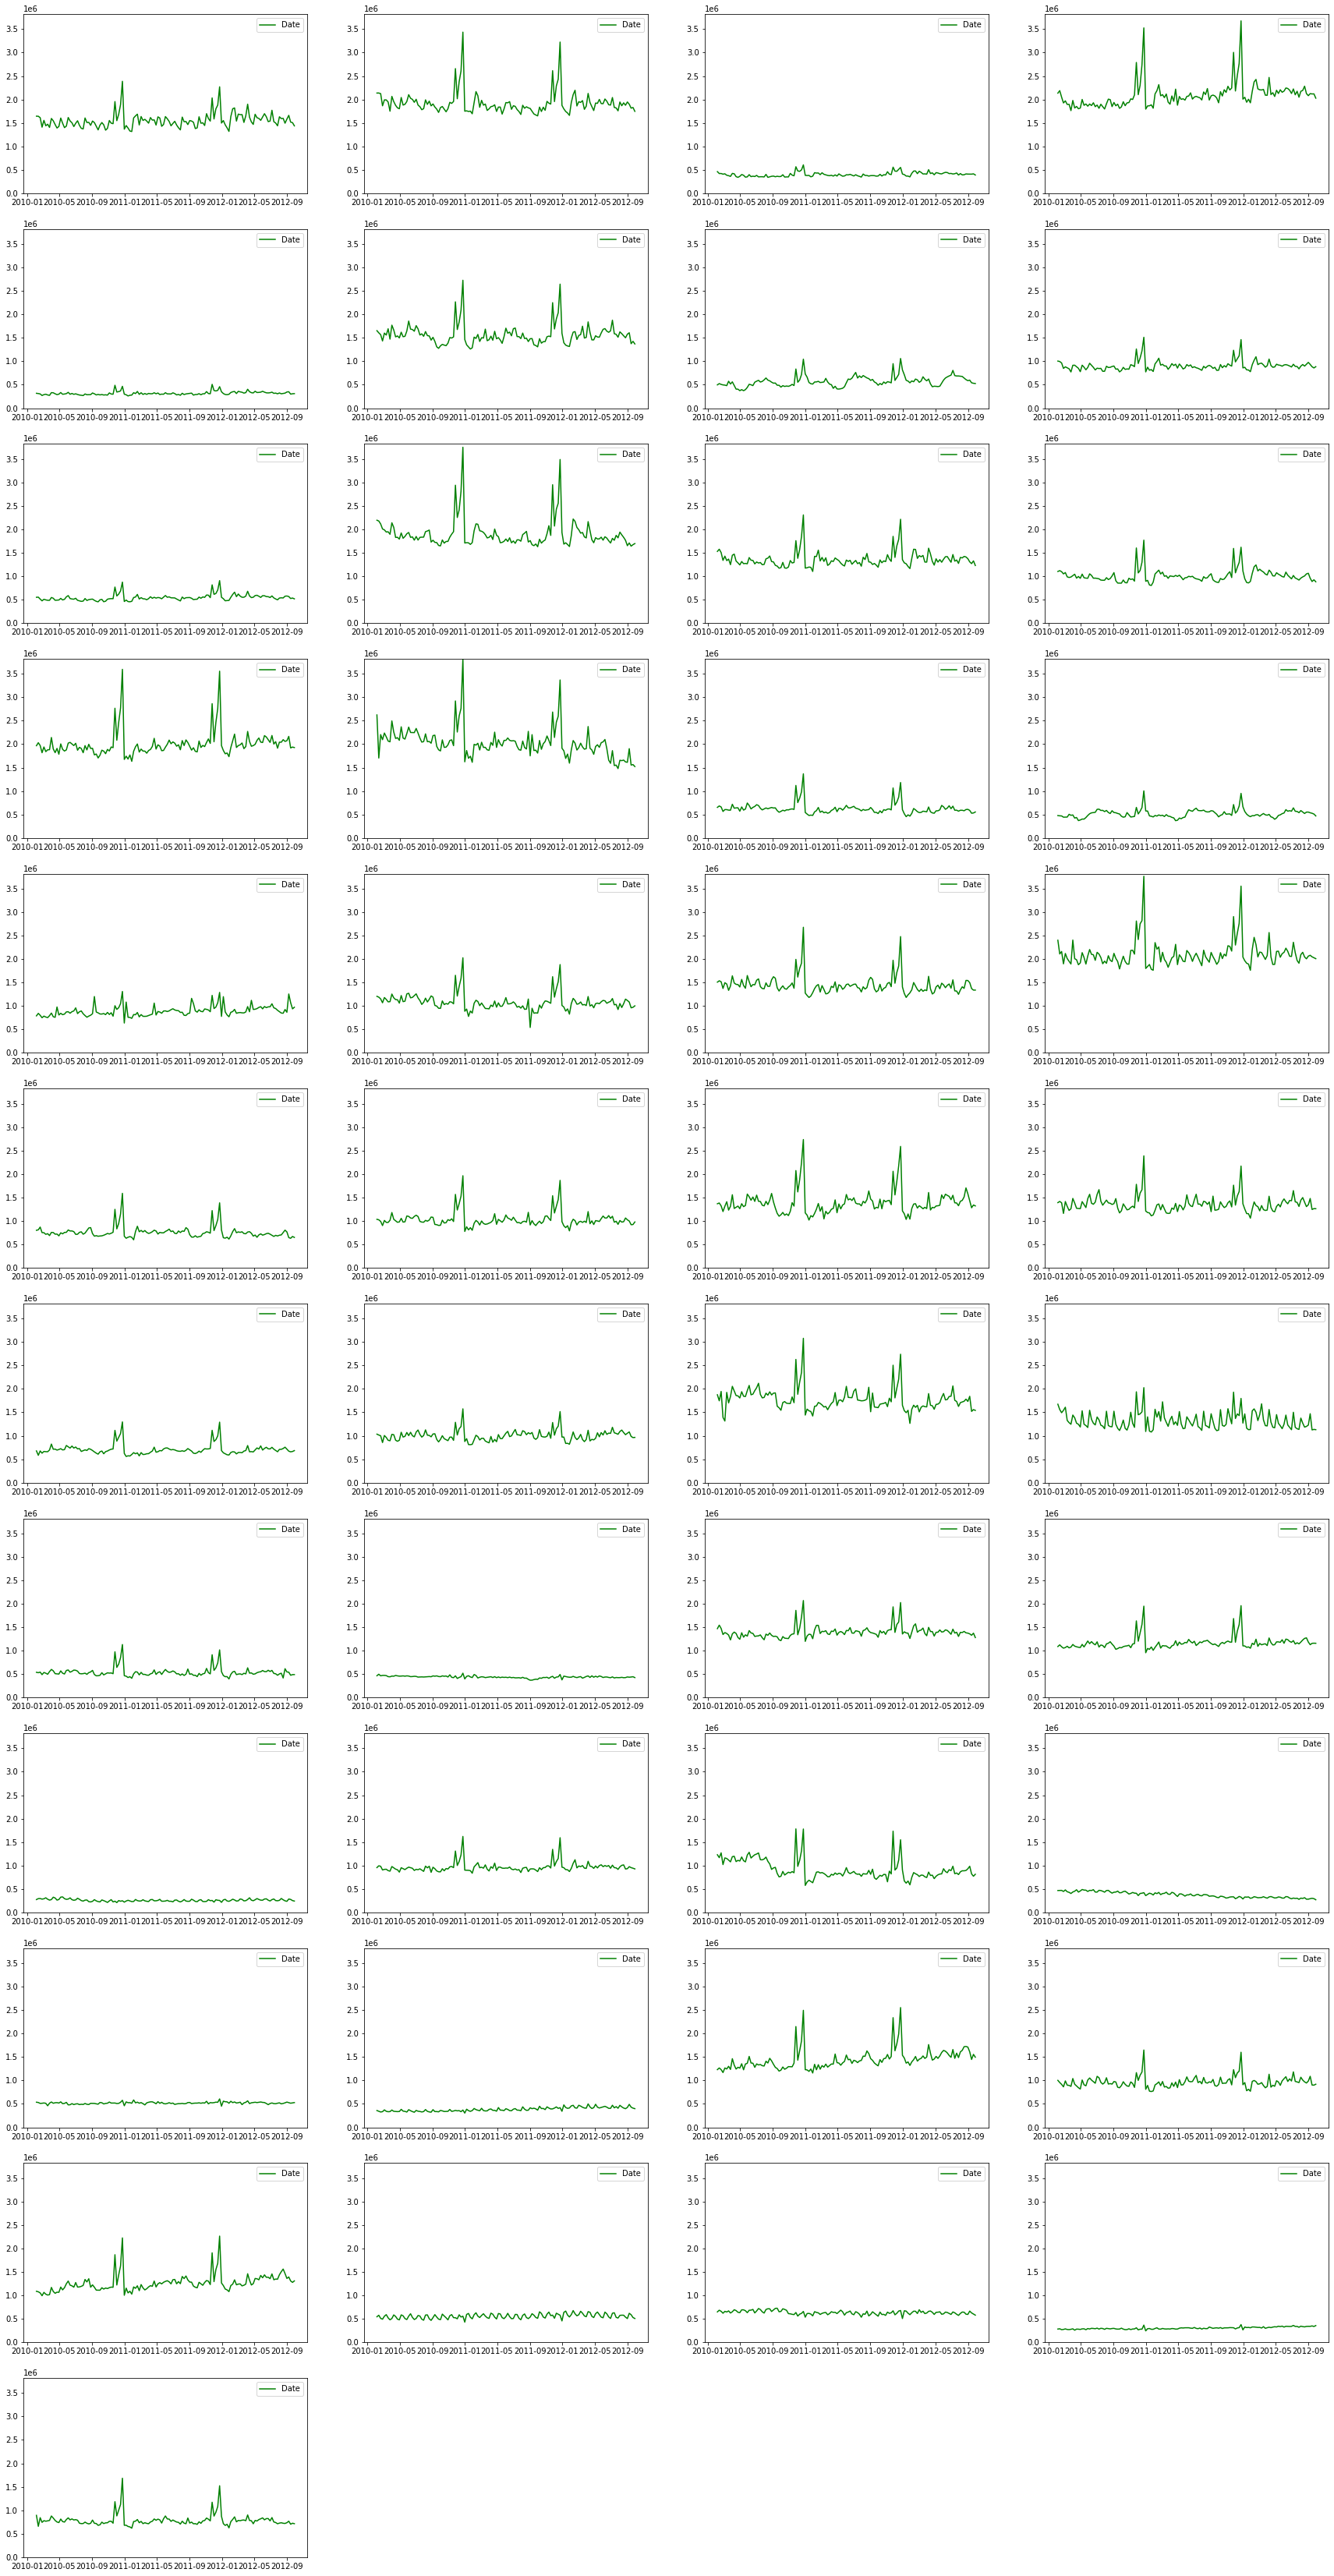

In [68]:
max_sales = max(train.Weekly_Sales)

fig = plt.figure(figsize=(30,60))
for store in range(1,max(train.Store)+1):
  storeset = train[train.Store==store]
  ax = fig.add_subplot(12, 4, store)
  ax.plot(storeset.Date, storeset.Weekly_Sales, label="Date", color='g')
  ax.legend()

  plt.ylim(0, max_sales)
plt.show()


대부분 지점의 판매량이 일정 시기에 많일 팔리는 패턴이다. 기간에 따른 반복이 진행된다.

**즉 연도에 따라 나눠서 진행해보자**

In [104]:
def holiday_to_number(isholiday):
    if isholiday == True:
        number = 1
    else:
        number = 0
    return number
def datedivide(df):
  df.Date = pd.to_datetime(df.Date, format="%d/%m/%Y")
  df['Week'] = df.Date.dt.isocalendar().week.apply(lambda x: int(x))
  df['Day'] = df.Date.dt.day.apply(lambda x: int(x))
  df['Year'] = df.Date.dt.year.apply(lambda x: int(x))
  df['Month'] = df.Date.dt.month.apply(lambda x: int(x))
  df['NumberHoliday'] = df['IsHoliday'].apply(holiday_to_number)
  return df

연도기준으로 일정한 같은 파형을 그리기에 연도른 나눠서 어떤 연도가 더 잘 예측하는지 확인해보도록하자

In [88]:
sample_submission = pd.read_csv('/content/drive/MyDrive/Dataset/sample_submission.csv')
train = pd.read_csv('/content/drive/MyDrive/Dataset/train.csv')
test = pd.read_csv('/content/drive/MyDrive/Dataset/test.csv')

<Figure size 2520x2520 with 0 Axes>

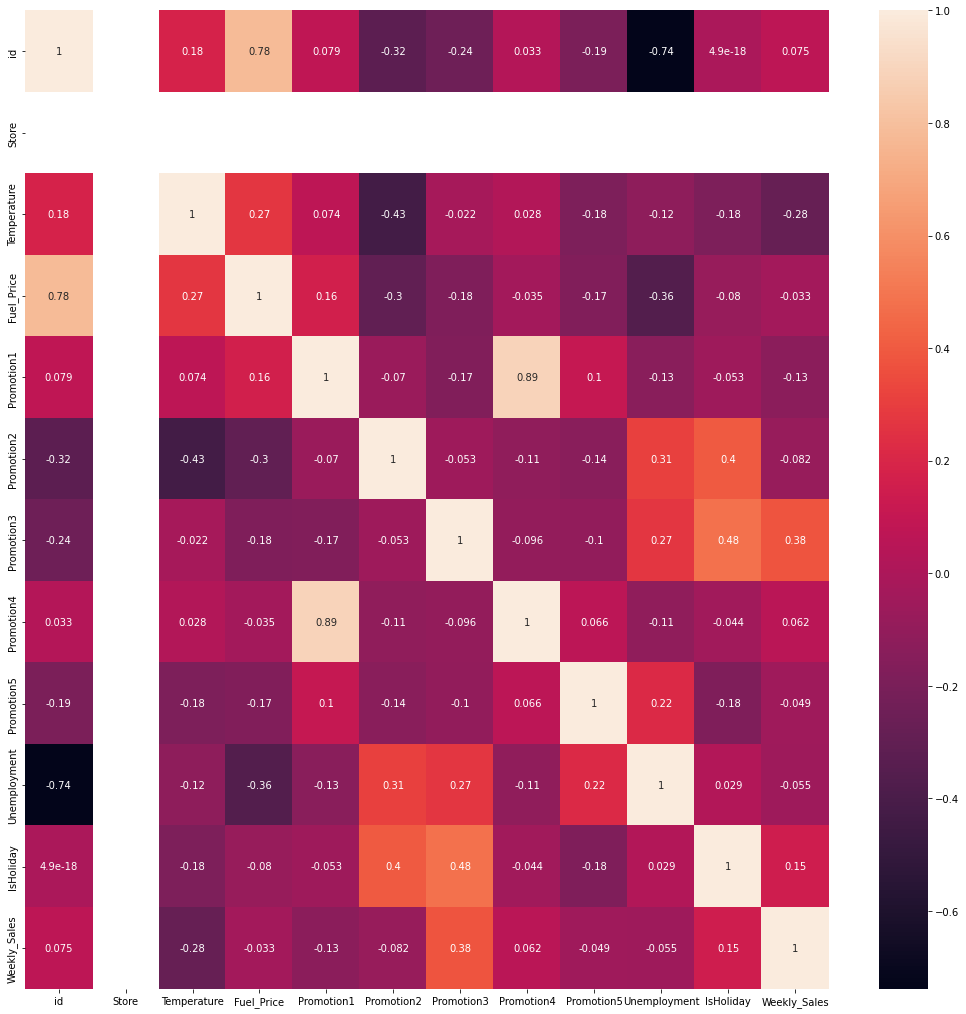

In [83]:
from matplotlib import dates

fig = plt.figure(figsize=(35,35)) ## 캔버스 생성
fig.set_facecolor('white') ## 캔버스 색상 설정

for i in range(11,12):
    train2 = train[train.Store == i]
    plt.figure(figsize=(18,18))
    sns.heatmap(data=train2.corr(), annot=True);
    
plt.show()

p

In [94]:
train= datedivide(train)
test= datedivide(test)

In [ ]:
features = ['Store', 'NumberHoliday', 'Week', 'Day', 'Month', 'Year']
models = []
# 학습을 위한 하이퍼파라미터 설정
model_params = {
    "n_estimators": 60,
    "min_child_weight": 3,
    "max_depth": 6
}

for store in range(1,max(train.Store)+1):
    train_store = train[train.Store==store]
    
    # 2010, 2011, 2012 년도 별로 데이터 분리
    # 2012-09에 대해 예측하려고 하기 때문에 2012년도는 9월을 포함하지 않음
    train_store_2010 = train_store[(train_store.Year==2010) & (train_store.Month<=9)]
    train_store_2011 = train_store[(train_store.Year==2011) & (train_store.Month<=9)]
    train_store_2012 = train_store[(train_store.Year==2012) & (train_store.Month<9)]
    
    # 2011, 2010 년도를 제외한 데이터 생성
    train_store_2010_2012 = pd.concat([train_store_2010, train_store_2012])
    train_store_2011_2012 = pd.concat([train_store_2011, train_store_2012])
    
    # 각각의 모델 학습
    model_2010_2012 = xgboost.XGBRegressor(**model_params)
    model_2010_2012.fit(train_store_2010_2012[features],
                        train_store_2010_2012.Weekly_Sales)
    
    model_2011_2012 = xgboost.XGBRegressor(**model_params)
    model_2011_2012.fit(train_store_2011_2012[features],
                        train_store_2011_2012.Weekly_Sales)
    
    # 2012년도 9월에 대해서 예측
    x_test = train_store[(train_store.Year==2012) & (train_store.Month==9)]
    pred_2010_2012 = model_2010_2012.predict(x_test[features])
    pred_2011_2012 = model_2011_2012.predict(x_test[features])
    
    # 예측 결과 평가
    rmse_2010_2012 = RMSE(pred_2010_2012, x_test.Weekly_Sales)
    rmse_2011_2012 = RMSE(pred_2011_2012, x_test.Weekly_Sales)

    
    # 오차가 더 적은 연도를 선택
    similar_year = 2010
    if rmse_2010_2012 > rmse_2011_2012:
        similar_year = 2011

    print(f"{store:02}", similar_year, rmse_2010_2012, rmse_2011_2012)
    
    # 전체 데이터로 학습
    train_store_target = pd.concat([
        train_store[(train_store.Year==similar_year) & (train_store.Month<=10)],
        train_store[(train_store.Year==2012)]
    ])

    model = xgboost.XGBRegressor(**model_params)
    model.fit(train_store_target[features], train_store_target.Weekly_Sales)
        
    models.append(model)

In [96]:
pred = []
for store in range(1, max(train.Store)+1):
    test_store = test[test.Store==store]
    
    y = models[store-1].predict(test_store[features])
    pred += y.tolist()

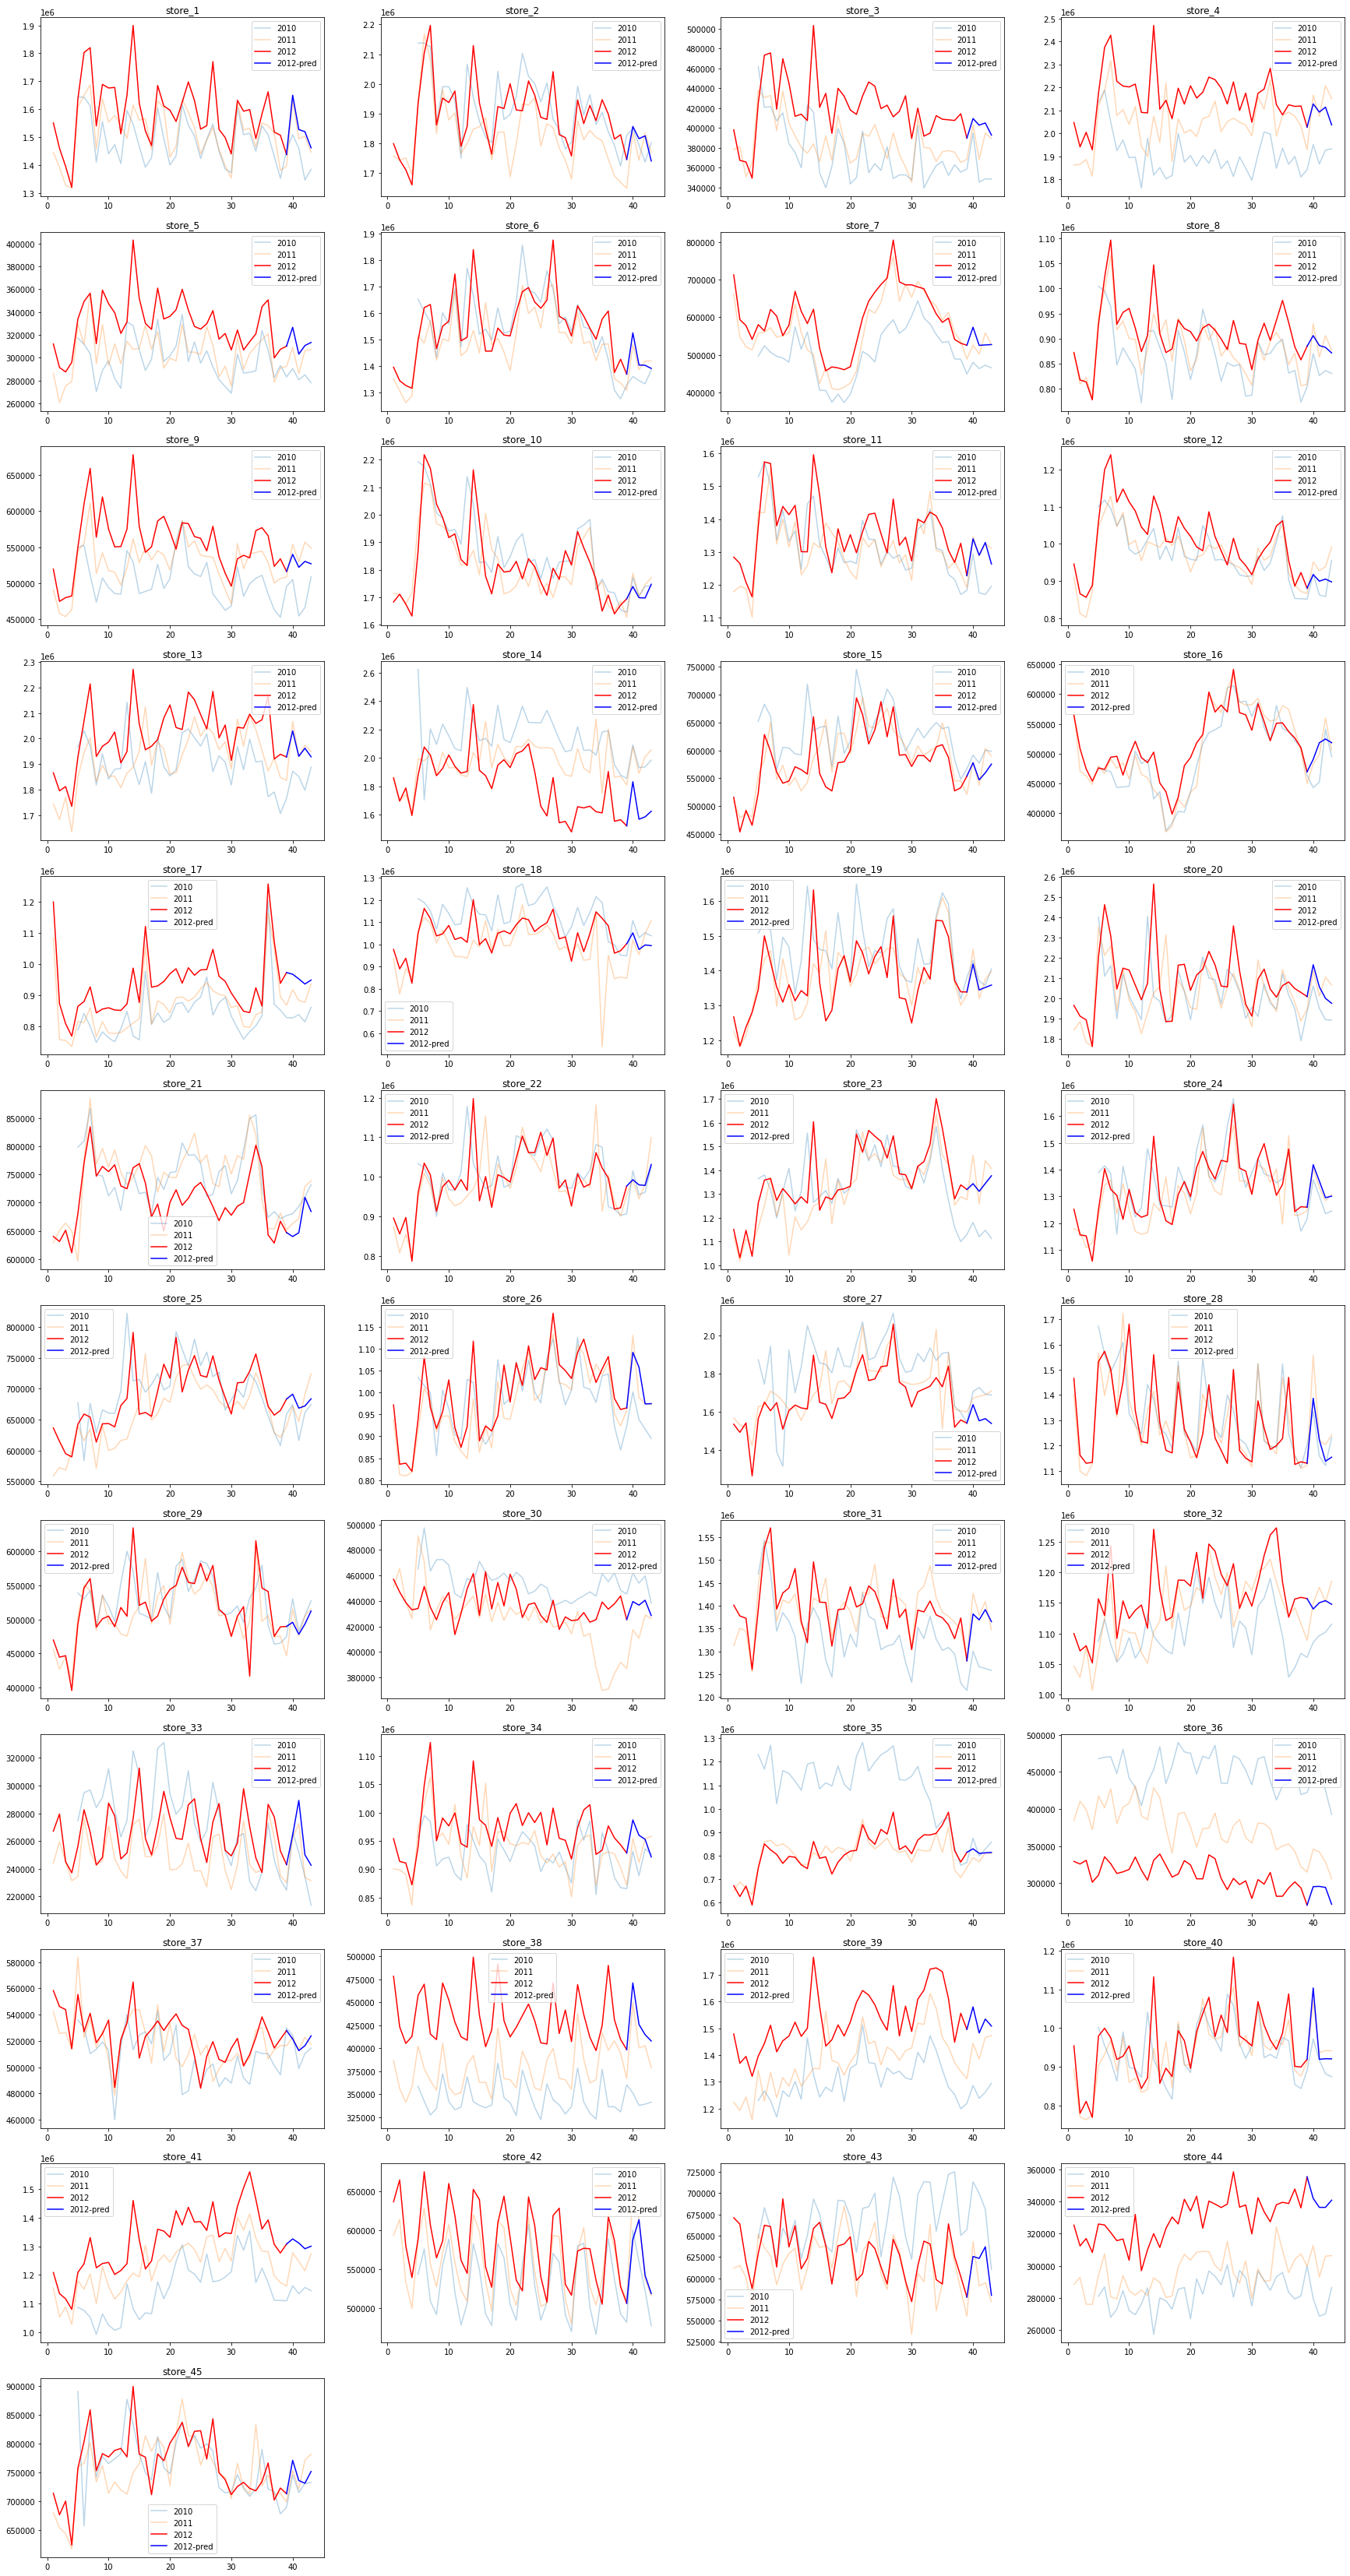

In [98]:
test_pred = test.copy()
test_pred["Weekly_Sales"] = pred
fig = plt.figure(figsize=(30,60))

for store in range(1,max(train.Store)+1):
    storeset = train[train.Store==store]
    storeset_2010 = storeset[(storeset.Year==2010) & (storeset.Month<=10)]
    storeset_2011 = storeset[(storeset.Year==2011) & (storeset.Month<=10)]
    storeset_2012 = storeset[(storeset.Year==2012) & (storeset.Month<=10)]
    
    test_pred_store = test_pred[test_pred.Store==store]
    
    # 그래프의 연속성을 위해 예측한 데이터의 전 주의 데이터도 넣어준다.
    test_pred_store = pd.concat([storeset_2012.iloc[-1:], test_pred_store])
    
    ax = fig.add_subplot(12, 4, store)
    
    plt.title(f"store_{store}")
    ax.plot(storeset_2010.Week, storeset_2010.Weekly_Sales, label="2010", alpha=0.3)
    ax.plot(storeset_2011.Week, storeset_2011.Weekly_Sales, label="2011", alpha=0.3)
    ax.plot(storeset_2012.Week, storeset_2012.Weekly_Sales, label="2012", color='r')
    ax.plot(test_pred_store.Week, test_pred_store.Weekly_Sales, label="2012-pred", color='b')
    ax.legend()
    
plt.show()

# RandomForest 사용

In [153]:
sample_submission = pd.read_csv('/content/drive/MyDrive/Dataset/sample_submission.csv')
train = pd.read_csv('/content/drive/MyDrive/Dataset/train.csv')
test = pd.read_csv('/content/drive/MyDrive/Dataset/test.csv')

In [154]:
def toDateTime(df):
  df['Date']= pd.to_datetime(df['Date'], format='%d/%m/%Y')
  return df
train= toDateTime(train)
test = toDateTime(test)

In [155]:
cutOff = pd.to_datetime('2012-03-23')
trains = train[train['Date'] < cutOff]
vals = train[(train['Date'] >= cutOff)]

In [156]:
def holiday_to_number(isholiday):
    if isholiday == True:
        number = 1
    else:
        number = 0
    return number
def datedivide(df):
  df.Date = pd.to_datetime(df.Date, format="%d/%m/%Y")
  df['Week'] = df.Date.dt.isocalendar().week.apply(lambda x: int(x))
  df['Day'] = df.Date.dt.day.apply(lambda x: int(x))
  df['Year'] = df.Date.dt.year.apply(lambda x: int(x))
  df['Month'] = df.Date.dt.month.apply(lambda x: int(x))
  df['NumberHoliday'] = df['IsHoliday'].apply(holiday_to_number)
  df= df.drop(['id'],axis=1)
  return df

In [ ]:
trains= datedivide(trains)
vals = datedivide(vals)
tests= datedivide(test)


In [158]:
target= 'Weekly_Sales'
X_train = trains.drop(columns=target)
y_train = trains[target]
X_val = vals.drop(columns=target)
y_val = vals[target]
X_test = tests

In [159]:
from pandas.core.common import random_state
from xgboost.sklearn import XGBRegressor
from category_encoders import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline

pipe = make_pipeline(
    XGBRegressor(n_estimators=200,
        random_state=2,
        n_job=-1,
        max_depth=10,
        eval_metric='rmse',
        learning_rate=0.01,
        objective='reg:squarederror',
    )
)
features = ['Store', 'NumberHoliday', 'Week', 'Day', 'Month', 'Year']
X_train= X_train[features]
X_val= X_val[features]
X_test = X_test[features]
pipe.fit(X_train, y_train);
y_pred = pipe.predict(X_val)


In [140]:
print('검증 정확도', pipe.score(X_val, y_val))


검증 정확도 0.85900337121402


In [161]:
pipe.fit(X_train_selected, y_train)
y_pred = pipe.predict(X_train_selected)
rmse = RMSE(y_train, y_pred)
y_pred = pipe.predict(X_val_selected)
rmse = RMSE(y_pred, y_val)
print("RMSE : ",rmse)

RMSE :  616710.2037345038
